In [200]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

print("Running...")
toc = time.perf_counter()
#ALL SETUP

thr_std=0.2


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

tic = time.perf_counter()
print("All data loaded in", tic-toc, "seconds")

Running...
All data loaded in 242.85930739999458 seconds


In [257]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    #given plane and event number, extract required information and threshold if required
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z
        AoI_truevtxx = u_truevtx_x
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z
        AoI_truevtxx = v_truevtx_x
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z
        AoI_truevtxx = w_truevtx_x
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

In [258]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)

    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0

In [259]:
def pick_xz(plane, event_number, i, thresholding=True, no_std=thr_std):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    return AoI_z[i], AoI_x[i]

In [260]:
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x

In [261]:
def rfunc(r):
    return 1/(1+r)

In [288]:
def rphi_score(plane, event_number, centre_coord, no_sectors=100, centre=0, r_dependence=rfunc, thresholding=True, no_std=thr_std):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    #centralise co-ordinates on the given point of interest
    
    centred_r = (centred_x**2 + centred_z**2)**0.5
    theta = np.arctan2(centred_x, centred_z)
    #convert co-ordinates to polar
    
    weight = r_dependence(centred_r)
    #weighting varies with the polar radius in the manner described by rfunc
    
    hist_data, hist_bins = np.histogram(theta, bins=no_sectors, range=(-np.pi+centre,np.pi+centre), weights=weight)
    #plt.hist(theta, bins=no_sectors, range=(-np.pi+centre,np.pi+centre), weights=weight)
    #plt.show()
    #plt.bar(hist_data, np.delete(hist_bins,-1),align='edge')
    #plt.show()
    
    
    hist_data2 = (hist_data - np.roll(hist_data, int(len(hist_data)/2)))[x>0]

    hist_sqr = hist_data2**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    return norm_score

In [289]:
def optimise_phi(plane, event_number, no_sectors=20, centre=0, r_dependence=rfunc, thresholding=True, no_std=thr_std, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in range(no_points):
        centre_co = pick_xz(plane, event_number, i, thresholding, no_std)
        score_arr[i] = rphi_score(plane, event_number, centre_coord=centre_co, no_sectors=no_sectors, centre=0, r_dependence=r_dependence)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind]

In [296]:
pl="u"
ev=0

In [297]:
z, x, score = optimise_phi(pl, ev)

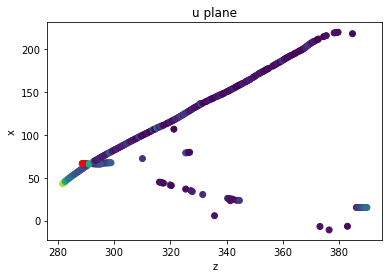

0.03104182180391628


In [298]:
plotter(pl, ev)
plt.plot(z,x,'ro')
plt.show()
print(score)

In [267]:
def accuracy(plane, function, no_events, thresholding=True, no_std=thr_std):
    Zvert = []
    Zvert_true = []
    Xvert = []
    Xvert_true = []
    
    for i in tqdm(range(no_events)):
        AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
        Zvert_place, Xvert_place = function(plane, i)[0], function(plane, i)[1]
        Zvert.append(Zvert_place)
        Xvert.append(Xvert_place)
        Zvert_true.append(Zvert_true_place)
        Xvert_true.append(Xvert_true_place)
    
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2
    
    print(delta_r2)
    data, bins = np.histogram(delta_r2, 30)
    
    plt.hist(data, bins=10)
    plt.show()

    return 0

In [2]:
import threading
n_events = 9310

def func_thread(plane, function, no_events, out):
    out.append(accuracy(plane, function, no_events))
x_ls =list(range(n_events))
thread_list = []
results = []
for x in x_ls:
 thread = threading.Thread(target=func_thread, args=(x, results))
 thread_list.append(thread)
for thread in thread_list:
 thread.start()
for thread in thread_list:
 thread.join()

Exception in thread Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-6:
Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-10:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py"

Exception in thread Thread-30:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread         self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Thread-31:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional

        Exception in thread Thread-56:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
        self.run()Traceback (most recent call last):
self.run()self.run()    self._target(*self._args, **self._kwargs)
TypeError    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'

  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread 
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
: 
self._target(*self._args, **self._kwargs)Thread-57:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner

TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread   File "C:\Users\owbun\anaconda3\lib\threading.py",

    Exception in thread Thread-76:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-77:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'


    Exception in thread Thread-99:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
        self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    Exception in thread self.run()Thread-100:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner

  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread     Thread-101:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self._target(*self._args, **self._kwargs)
TypeError: func_thread

Exception in thread Thread-121:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)    
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread     Thread-122:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
TypeError    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
Ty

    TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self.run()    
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
        self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
        Exception in thread self._target(*self._args, **self._kwargs)self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self._target(*self._args, **self._kwargs)
TypeError
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self.run()Thread-146:
Traceback (most recent call last):

  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 

Exception in thread Thread-166:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-167:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread Thread-168:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    Exception in thread Thread-16

    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-188:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-189:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Exception in thread Thread-190Thread-191:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\li

    Exception in thread self._target(*self._args, **self._kwargs)Thread-211:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner

TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'Exception in thread 
Exception in thread Thread-213:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-212:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Thread-214:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-215:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\li

    Exception in thread self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Thread-234:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-235:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
        self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self._target(*self._args, **self._kwargs)
Ty

Exception in thread Thread-257    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread Thread-258:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-259:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-260:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  F

self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
: :
func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-282    :
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()
      File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread self.run()    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run

  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    Thread-283:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self.run()
  File "C:\Users\owbun\

    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    Exception in thread self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-301Thread-302:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out

    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-325:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-326:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-327:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  

:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-348:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-349:
Traceback (most recent call last):
  File "C:\

    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-370:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread     self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Thread-371:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-372:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in 

    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread     self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-395:
Traceback (most recent call last):
Thread-394  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target

Exception in thread Thread-416:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    Exception in thread Thread-417:
self.run()Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run

      File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread     Thread-418self._target(*self._args, **self._kwargs)
TypeError: func_thread

    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-440:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread     self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Thread-441:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
Ty

    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'    
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-463:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
        self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Exception in thread Thread-464Thread-465:
T

self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-487:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 r

:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-509:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-510:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
        self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: '

        self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-531:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-532:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-533Exception in threa

Exception in thread Exception in thread Thread-553:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-552:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-554:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-555    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
:
    Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread     self.run()Thread-556self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
:
Traceback (most recent call last):
  File "C:\Users\owbu

    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    Exception in thread Thread-576:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-577:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\

    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-599:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
            self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Exception in thread self._target(*self._args, **self._kwargs)
TypeError: Exception in thread Thread-600:
Traceback (most recent call last):
Thread-601Thread-602:
Traceback (

    Exception in thread Thread-621:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-622:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread     self._target(*self._args, **self._kwargs)
Thread-623:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    Exception in thread self.run()Thread-624:
Traceback (most recent call last):
Exception in thread   File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner


    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", 

Exception in thread Thread-644:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Exception in thread Thread-645Thread-646:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
:
Exception in thread Traceback (most recent call last):
Thread-647:
Traceback (most recent call last)

Exception in thread     self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-667Thread-668:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-669:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
        self._target(*self._args, **self._kwargs)
TypeErrorException in thread self._target(*self._args, **self._kwargs)        : func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    Thread-670self._target(*self._args, **se

    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    Exception in thread Thread-689:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-690    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-691:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    Exception in thread self.run()
  File "C:\Users\owbun\anaconda3

Exception in thread     self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Thread-712:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Exception in thread Thread-714:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-713:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-715:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  F

    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Exception in thread Thread-735Thread-736:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread     Exception in thread Thre

self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
        self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-757:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-758:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-759:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _boo

Exception in thread Thread-779:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-780:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread     Thread-781:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'Exception in thread 
Thread-782:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-783:
Traceb

    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-803:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread     self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Thread-804:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\

    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-826:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread Thread-827:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()    
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-828:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 re

Exception in thread     Exception in thread Thread-849:
self._target(*self._args, **self._kwargs)Thread-848Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner

TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    Exception in thread Thread-850:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Exception in thread Thread-851    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", 

Thread-872:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread     self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Thread-873:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_ev

self._target(*self._args, **self._kwargs)Thread-895: func_thread() missing 2 required positional arguments: 'no_events' and 'out'

TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-896:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-897:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread self.run()Thread-898:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\thr

Exception in thread Thread-918:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread Thread-919:
Traceback (most recent call last):
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-920:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-921:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py"

Exception in thread Thread-940:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-941:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread Thread-942:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-943:
T

    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    Exception in thread self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-964:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-963:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-965:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **s

Exception in thread         self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Thread-989:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-990:
Traceback (most recent call last):
  File "C:\Users\owbun\anaco

self._target(*self._args, **self._kwargs)    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run

TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'

Exception in thread Thread-1010:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thr

Exception in thread Thread-1032:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
        self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Exception in thread Thread-1034:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 9

Exception in thread Thread-1053:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-1054:
Exception in thread Thread-1055:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-1056:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-1057:
Traceback (most recent call last):
  File "C:\Users\owbun\anacond

    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread     Thread-1078:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread     self._target(*self._args, **self._kwargs)Thread-1079:
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Traceback (most recent call last):

  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda

    self.run()self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run

  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-1101:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread     Thread-1102:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-1103:
Traceback (most r

Exception in thread Thread-1124:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner

Exception in thread Thread-1125:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
        self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
        self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread     self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required 

Exception in thread Thread-1147:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread self._target(*self._args, **self._kwargs)    
TypeErrorException in thread Thread-1148self._target(*self._args, **self._kwargs): func_thread() missing 2 required positional arguments: 'no_events' and 'out'
        :
Thread-1149self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner

self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py

    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-1169:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-1170:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-1171:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, 

self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread     self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Thread-1192:
Exception in thread Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Thread-1193:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Exception in thread Thread-1194:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-1196:
Traceback (most recent call last):
  File "C:\Users\owbun\anacond

Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
        self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-1216:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
Exception in thread Thread-1217:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    Exception

Exception in thread Thread-1237:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    Exception in thread     Thread-1238:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self._target(*self._args, **self._kwargs)self.run()
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'

  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread Thread-1239    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
Exception in thread :
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
    self._

self._target(*self._args, **self._kwargs)Thread-1261:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner

    self._target(*self._args, **self._kwargs)self.run()
TypeError: func_thread() missing 2 required positional arguments: 'no_events' and 'out'
TypeError: 
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
func_thread() missing 2 required positional arguments: 'no_events' and 'out'    
Exception in thread self.run()Thread-1262:
Traceback (most recent call last):
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 932, in _bootstrap_inner

  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line 870, in run
    Exception in thread self.run()
  File "C:\Users\owbun\anaconda3\lib\threading.py", line

In [269]:
#accuracy(pl, optimise_phi, n_events)